In [1]:
import os
import numpy as np
import cv2
import scipy.io as sio
from random import randint
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Paths
DATASET_FOLDER = '/user/HS402/rk01219/Downloads/Sem1/CV_01/0_1/msrc_objcategimagedatabase_v2/MSRC_ObjCategImageDatabase_v2/'
OUT_FOLDER = '/user/HS402/rk01219/Downloads/Sem1/Computer Vision 3/descriptors'


# Function to extract SIFT features
def extract_sift_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(nfeatures=1000, nOctaveLayers=4, contrastThreshold=0.03, edgeThreshold=15, sigma=1.2)
    _, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

# Load all descriptors and categories from images
all_descriptors = []
ALLFILES = []
ALLCATEGORIES = []

# Loop through images and extract descriptors
for filename in os.listdir(os.path.join(DATASET_FOLDER, 'Images')):
    if filename.endswith(".bmp"):
        print(f"Processing: {filename}")  # Print the file name being processed
        img_path = os.path.join(DATASET_FOLDER, 'Images', filename)
        img = cv2.imread(img_path)
        descriptors = extract_sift_features(img)
        
        if descriptors is not None:
            all_descriptors.extend(descriptors)
            ALLFILES.append(filename)
            category_num = int(filename.split('_')[0])
            ALLCATEGORIES.append(category_num)

# Convert all descriptors to numpy array
all_descriptors = np.array(all_descriptors)

# Final print statement for completion
print("Process complete.")


Processing: 8_22_s.bmp
Processing: 12_29_s.bmp
Processing: 17_20_s.bmp
Processing: 11_5_s.bmp
Processing: 12_15_s.bmp
Processing: 20_1_s.bmp
Processing: 9_16_s.bmp
Processing: 5_27_s.bmp
Processing: 3_26_s.bmp
Processing: 18_23_s.bmp
Processing: 17_27_s.bmp
Processing: 5_29_s.bmp
Processing: 3_28_s.bmp
Processing: 20_12_s.bmp
Processing: 13_7_s.bmp
Processing: 19_21_s.bmp
Processing: 13_22_s.bmp
Processing: 7_18_s.bmp
Processing: 4_26_s.bmp
Processing: 9_12_s.bmp
Processing: 10_18_s.bmp
Processing: 2_25_s.bmp
Processing: 9_15_s.bmp
Processing: 20_10_s.bmp
Processing: 14_28_s.bmp
Processing: 9_23_s.bmp
Processing: 2_13_s.bmp
Processing: 18_13_s.bmp
Processing: 12_14_s.bmp
Processing: 2_16_s.bmp
Processing: 4_25_s.bmp
Processing: 8_1_s.bmp
Processing: 9_21_s.bmp
Processing: 4_20_s.bmp
Processing: 11_3_s.bmp
Processing: 14_18_s.bmp
Processing: 13_16_s.bmp
Processing: 4_21_s.bmp
Processing: 12_20_s.bmp
Processing: 2_4_s.bmp
Processing: 14_1_s.bmp
Processing: 12_4_s.bmp
Processing: 18_12_s.

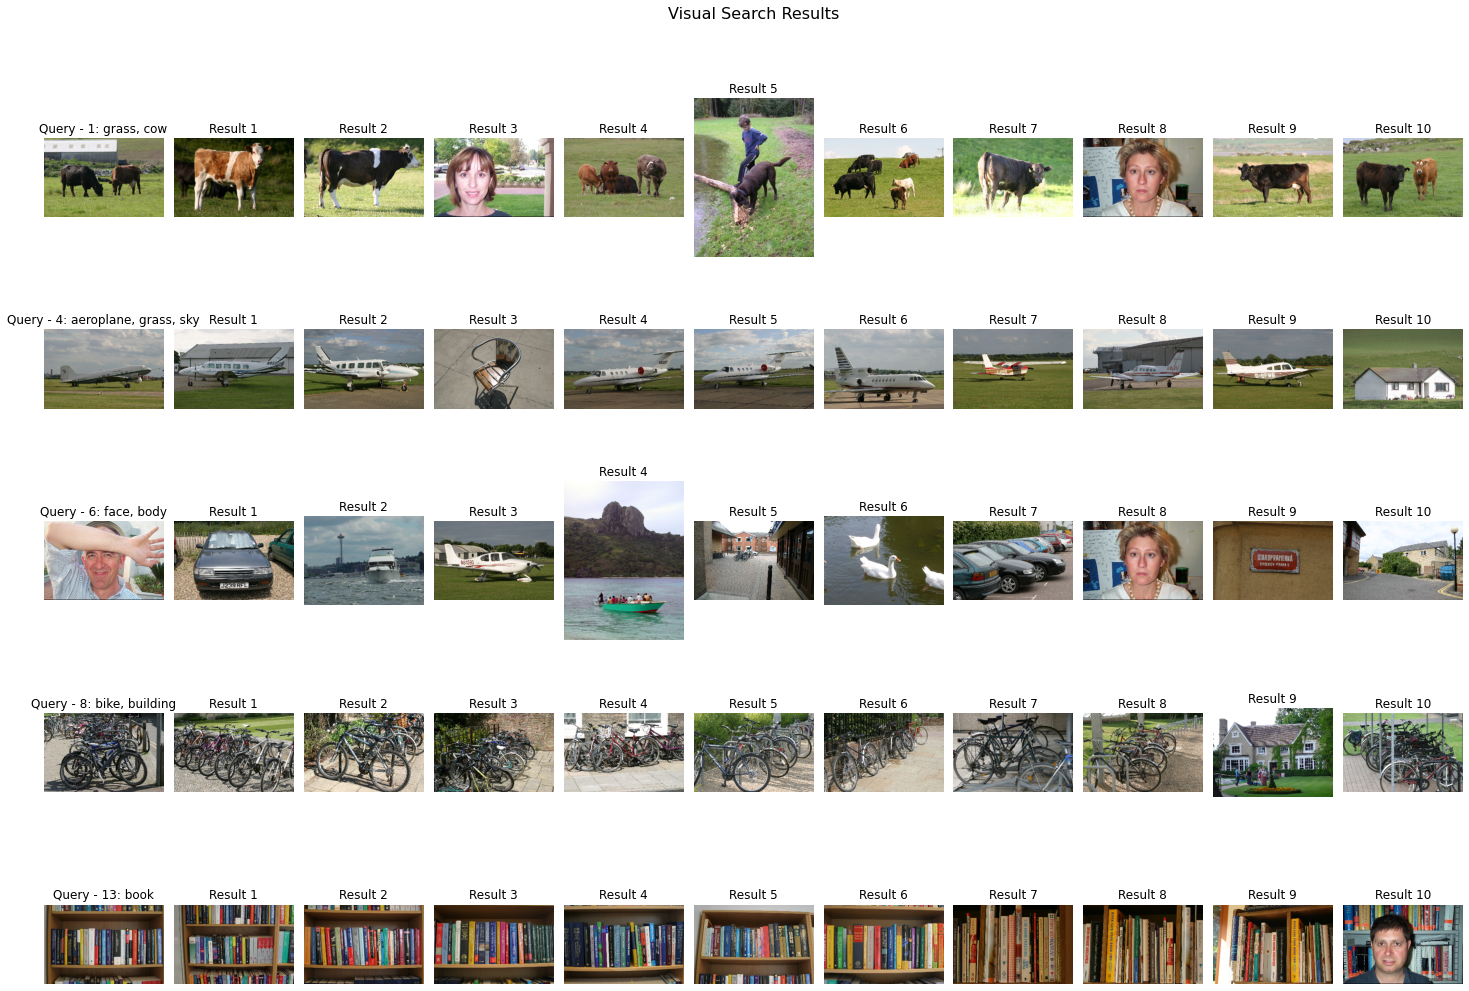

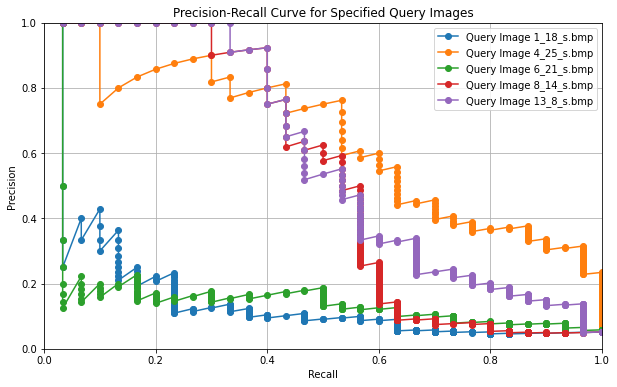

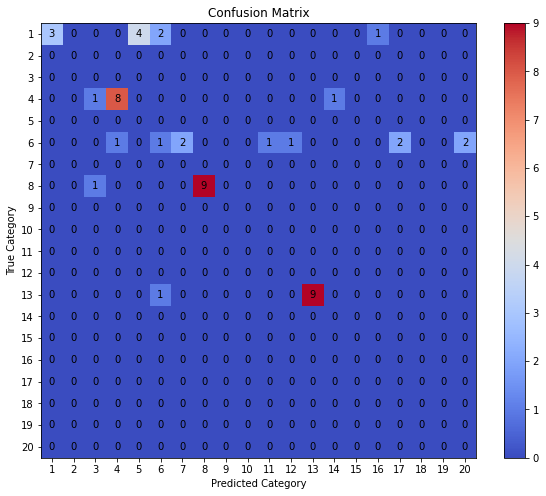

In [2]:
# Define number of clusters for visual words and query images
NUM_CLUSTERS = 110
QUERY_IMAGES = ["1_18_s.bmp", "4_25_s.bmp", "6_21_s.bmp", "8_14_s.bmp", "13_8_s.bmp"]
IMAGES_PER_CATEGORY = 10  # Set to the number of images to display per query

# Define category mappings
CATEGORY_LABELS = {
    1: "grass, cow", 2: "tree, grass, sky", 3: "building, sky", 4: "aeroplane, grass, sky",
    5: "cow, grass, mount", 6: "face, body", 7: "car, building", 8: "bike, building",
    9: "sheep, grass", 10: "flower", 11: "sign", 12: "bird, sky, grass, water",
    13: "book", 14: "chair", 15: "cat", 16: "dog", 17: "road, building", 
    18: "water, boat", 19: "body, face", 20: "water, boat, sky, mount"
}

# Step 1: K-means clustering to create a codebook
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0)
kmeans.fit(all_descriptors)
codebook = kmeans.cluster_centers_

# Step 2: Generate histograms of visual words for each image
histograms = []

for filename in os.listdir(os.path.join(DATASET_FOLDER, 'Images')):
    if filename.endswith(".bmp"):
        img_path = os.path.join(DATASET_FOLDER, 'Images', filename)
        img = cv2.imread(img_path)
        descriptors = extract_sift_features(img)
        histogram = np.zeros(len(codebook))
        if descriptors is not None:
            words = kmeans.predict(descriptors)
            for word in words:
                histogram[word] += 1
        histograms.append(histogram)

# Convert histograms to a numpy array
histograms = np.array(histograms)

# Step 3: Visual search for multiple query images and display results
precision_list = []
recall_list = []

# Set up figure for query results
fig, axes = plt.subplots(len(QUERY_IMAGES), IMAGES_PER_CATEGORY + 1, figsize=(20, 3 * len(QUERY_IMAGES)))
fig.suptitle("Visual Search Results", fontsize=16)

for idx, query_image_name in enumerate(QUERY_IMAGES):
    query_idx = ALLFILES.index(query_image_name)
    query_histogram = histograms[query_idx]
    query_category = ALLCATEGORIES[query_idx]
    
    # Compute distances from the query to all other histograms
    distances = []
    for i, hist in enumerate(histograms):
        distance = np.linalg.norm(query_histogram - hist)
        distances.append((distance, i))
    distances.sort(key=lambda x: x[0])

    # Display the query image
    query_image_path = os.path.join(DATASET_FOLDER, 'Images', query_image_name)
    query_img = cv2.imread(query_image_path)
    query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
    category_name = CATEGORY_LABELS[query_category]
    axes[idx, 0].imshow(query_img)
    axes[idx, 0].set_title(f"Query - {query_category}: {category_name}")
    axes[idx, 0].axis('off')

    # Show top results for the query
    for i in range(IMAGES_PER_CATEGORY):
        img_index = distances[i + 1][1]  # Skipping the query image itself
        img_path = os.path.join(DATASET_FOLDER, 'Images', ALLFILES[img_index])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx, i + 1].imshow(img)
        axes[idx, i + 1].axis('off')
        axes[idx, i + 1].set_title(f"Result {i + 1}")

    # Calculate Precision-Recall for this query
    relevant_items = [i for i in range(len(ALLFILES)) if ALLCATEGORIES[i] == query_category]
    total_relevant = len(relevant_items)

    precision_category = []
    recall_category = []

    for n in range(1, len(ALLFILES) + 1):
        retrieved = distances[:n]
        retrieved_categories = [ALLCATEGORIES[i[1]] for i in retrieved]
        relevant_retrieved = sum(1 for cat in retrieved_categories if cat == query_category)
        
        precision = relevant_retrieved / n
        recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0
        precision_category.append(precision)
        recall_category.append(recall)

    precision_list.append(precision_category)
    recall_list.append(recall_category)

# Display the query results
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot Precision-Recall curve for each query image
plt.figure(figsize=(10, 6))
for idx, query_image_name in enumerate(QUERY_IMAGES):
    plt.plot(recall_list[idx], precision_list[idx], marker='o', label=f"Query Image {query_image_name}")
plt.title('Precision-Recall Curve for Specified Query Images')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

# Confusion Matrix for 20 categories
confusion_matrix = np.zeros((20, 20), dtype=int)

for idx, query_image_name in enumerate(QUERY_IMAGES):
    query_idx = ALLFILES.index(query_image_name)
    query_category = ALLCATEGORIES[query_idx]
    
    # Compute distances for the query
    distances = []
    for i, hist in enumerate(histograms):
        distance = np.linalg.norm(histograms[query_idx] - hist)
        distances.append((distance, i))
    distances.sort(key=lambda x: x[0])

    # Consider the top results for confusion matrix
    for i in range(IMAGES_PER_CATEGORY):
        img_index = distances[i + 1][1]
        retrieved_category = ALLCATEGORIES[img_index]
        confusion_matrix[query_category - 1, retrieved_category - 1] += 1

# Plot the confusion matrix with annotations using the 'coolwarm' color map
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, cmap='coolwarm', interpolation='nearest')  # Use 'coolwarm' color map
plt.title("Confusion Matrix")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.colorbar()

# Set x and y ticks
plt.xticks(np.arange(20), labels=np.arange(1, 21))
plt.yticks(np.arange(20), labels=np.arange(1, 21))

# Annotate each cell with the count
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color="black")

plt.show()



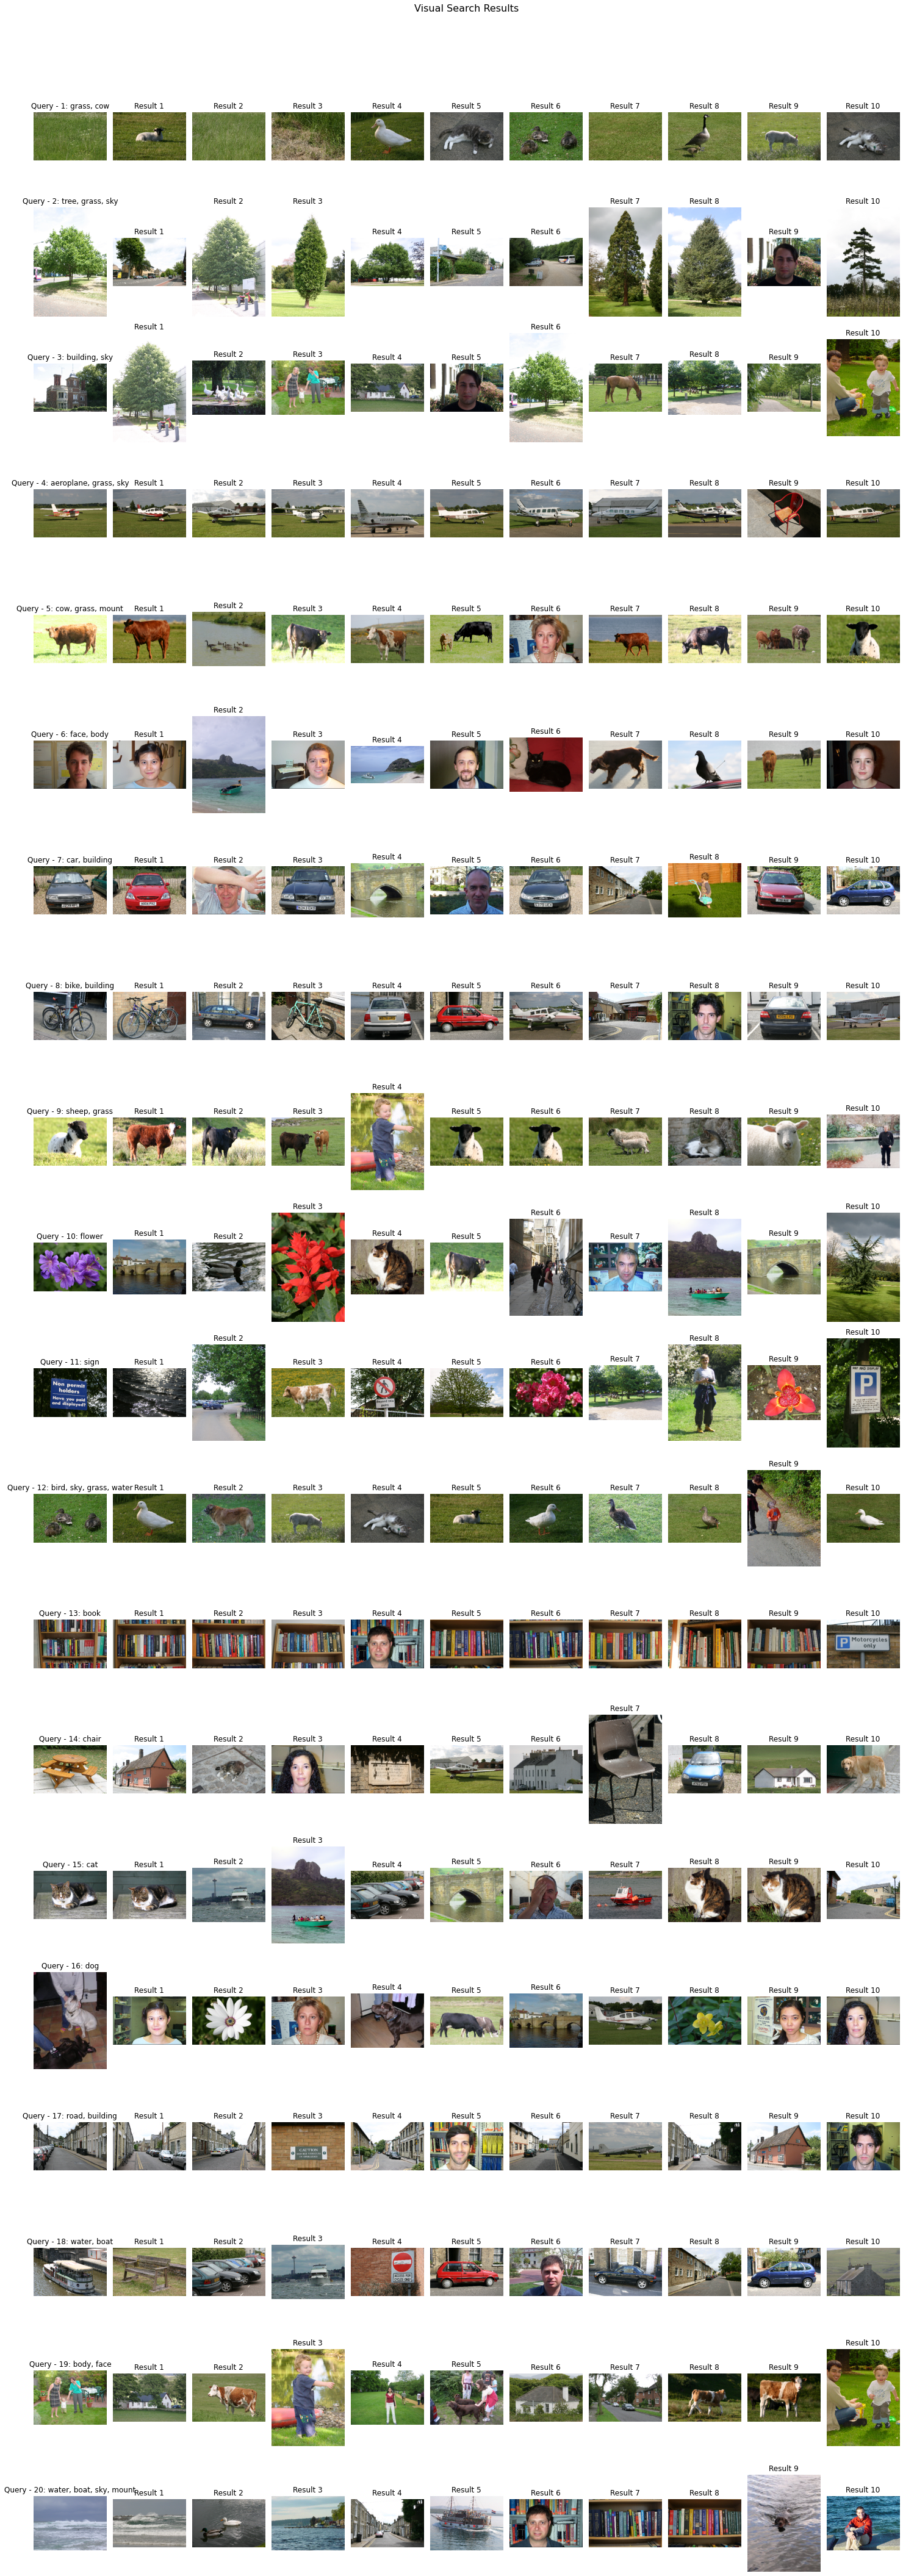

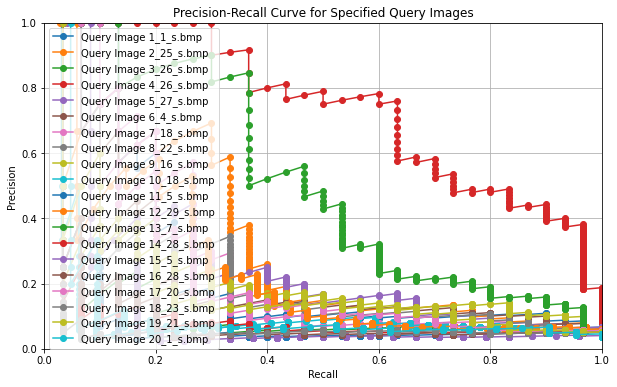

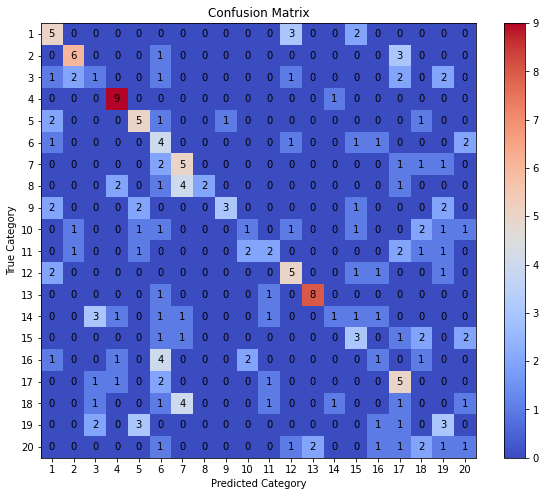

In [3]:
# Define number of clusters for visual words and images per query

IMAGES_PER_CATEGORY = 10  # Number of images to display per query

# Define category mappings
CATEGORY_LABELS = {
    1: "grass, cow", 2: "tree, grass, sky", 3: "building, sky", 4: "aeroplane, grass, sky",
    5: "cow, grass, mount", 6: "face, body", 7: "car, building", 8: "bike, building",
    9: "sheep, grass", 10: "flower", 11: "sign", 12: "bird, sky, grass, water",
    13: "book", 14: "chair", 15: "cat", 16: "dog", 17: "road, building", 
    18: "water, boat", 19: "body, face", 20: "water, boat, sky, mount"
}

# Step 1: K-means clustering to create a codebook
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0)
kmeans.fit(all_descriptors)
codebook = kmeans.cluster_centers_

# Step 2: Generate histograms of visual words for each image
histograms = []

for filename in os.listdir(os.path.join(DATASET_FOLDER, 'Images')):
    if filename.endswith(".bmp"):
        img_path = os.path.join(DATASET_FOLDER, 'Images', filename)
        img = cv2.imread(img_path)
        descriptors = extract_sift_features(img)
        histogram = np.zeros(len(codebook))
        if descriptors is not None:
            words = kmeans.predict(descriptors)
            for word in words:
                histogram[word] += 1
        histograms.append(histogram)

# Convert histograms to a numpy array
histograms = np.array(histograms)

# Step 3: Select one query image from each category
QUERY_IMAGES = []

# Ensure one image per category as query
for category in range(1, 21):
    # Find one image from the category
    category_files = [ALLFILES[i] for i in range(len(ALLFILES)) if ALLCATEGORIES[i] == category]
    query_image = category_files[0]  # Select the first image in the category as query
    QUERY_IMAGES.append(query_image)

# Step 4: Visual search for multiple query images and display results
precision_list = []
recall_list = []

# Set up figure for query results
fig, axes = plt.subplots(len(QUERY_IMAGES), IMAGES_PER_CATEGORY + 1, figsize=(20, 3 * len(QUERY_IMAGES)))
fig.suptitle("Visual Search Results", fontsize=16)

for idx, query_image_name in enumerate(QUERY_IMAGES):
    query_idx = ALLFILES.index(query_image_name)
    query_histogram = histograms[query_idx]
    query_category = ALLCATEGORIES[query_idx]
    
    # Compute distances from the query to all other histograms
    distances = []
    for i, hist in enumerate(histograms):
        distance = np.linalg.norm(query_histogram - hist)
        distances.append((distance, i))
    distances.sort(key=lambda x: x[0])

    # Display the query image
    query_image_path = os.path.join(DATASET_FOLDER, 'Images', query_image_name)
    query_img = cv2.imread(query_image_path)
    query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
    category_name = CATEGORY_LABELS[query_category]
    axes[idx, 0].imshow(query_img)
    axes[idx, 0].set_title(f"Query - {query_category}: {category_name}")
    axes[idx, 0].axis('off')

    # Show top results for the query
    for i in range(IMAGES_PER_CATEGORY):
        img_index = distances[i + 1][1]  # Skipping the query image itself
        img_path = os.path.join(DATASET_FOLDER, 'Images', ALLFILES[img_index])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx, i + 1].imshow(img)
        axes[idx, i + 1].axis('off')
        axes[idx, i + 1].set_title(f"Result {i + 1}")

    # Calculate Precision-Recall for this query
    relevant_items = [i for i in range(len(ALLFILES)) if ALLCATEGORIES[i] == query_category]
    total_relevant = len(relevant_items)

    precision_category = []
    recall_category = []

    for n in range(1, len(ALLFILES) + 1):
        retrieved = distances[:n]
        retrieved_categories = [ALLCATEGORIES[i[1]] for i in retrieved]
        relevant_retrieved = sum(1 for cat in retrieved_categories if cat == query_category)
        
        precision = relevant_retrieved / n
        recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0
        precision_category.append(precision)
        recall_category.append(recall)

    precision_list.append(precision_category)
    recall_list.append(recall_category)

# Display the query results
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot Precision-Recall curve for each query image
plt.figure(figsize=(10, 6))
for idx, query_image_name in enumerate(QUERY_IMAGES):
    plt.plot(recall_list[idx], precision_list[idx], marker='o', label=f"Query Image {query_image_name}")
plt.title('Precision-Recall Curve for Specified Query Images')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

# Confusion Matrix for 20 categories
confusion_matrix = np.zeros((20, 20), dtype=int)

for idx, query_image_name in enumerate(QUERY_IMAGES):
    query_idx = ALLFILES.index(query_image_name)
    query_category = ALLCATEGORIES[query_idx]
    
    # Compute distances for the query
    distances = []
    for i, hist in enumerate(histograms):
        distance = np.linalg.norm(histograms[query_idx] - hist)
        distances.append((distance, i))
    distances.sort(key=lambda x: x[0])

    # Consider the top results for confusion matrix
    for i in range(IMAGES_PER_CATEGORY):
        img_index = distances[i + 1][1]
        retrieved_category = ALLCATEGORIES[img_index]
        confusion_matrix[query_category - 1, retrieved_category - 1] += 1

# Plot the confusion matrix with annotations using the 'coolwarm' color map
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, cmap='coolwarm', interpolation='nearest')  # Use 'coolwarm' color map
plt.title("Confusion Matrix")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.colorbar()

# Set x and y ticks
plt.xticks(np.arange(20), labels=np.arange(1, 21))
plt.yticks(np.arange(20), labels=np.arange(1, 21))

# Annotate each cell with the count
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color="black")

plt.show()
